# Building the FPGA firmware

Now that we have created our XGBoost model, we use another library, `Conifer`, to "translate" it to an FPGA firmware.  
Conifer translate the model first in _HLS_ (C/C++) and then build the _HDL_ code (VHDL/Verilog) using a third backend software which is either `Vitis` or `Vivado`, which requires installation.

# Libraries

We include the libraries needed to run this part:

In [1]:
import conifer
import xgboost as xgb
import json
import pandas as pd
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn import metrics

Could not import conifer ydf converter
/opt/conda/envs/fpga-env/lib/python3.10/site-packages/pynqutils/build_utils/xsa_parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/envs/fpga-env/lib/python3.10/site-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


# Write the model in HLS

We load the model from part 1

In [2]:
import os

# Change the current working directory to where the file is located
os.chdir('repo')

In [3]:
model = xgb.XGBClassifier()
model.load_model('best_model.json')

Since building the firmware specifically for our board (PYNQ-Z2) can be time-consuming, we first create a more generic firmware for debugging purposes.  
This approach allows us to quickly test and validate the model conversion process before investing additional time in board-specific synthesis and packaging.  
By debugging with a generic firmware, we can identify and resolve potential issues early, making the workflow more efficient.

In [4]:
# Load test data
data = pd.read_hdf('data.h5')
test_data = data[data['is_train']==False]

The next cell of code is needed to tell Conifer the paths where to find Vivado, Vitis, the C/C++ compilers and others important files. We put execute the cell after loading the model and the data because these next lines of code will change the working directory of the notebook.  
Mind that, in another environment, paths might be different.

In [5]:
# INFN-MIB Cloud Environment Paths
import os
import sys
import sysconfig
import pybind11
# Add Viavado bin
os.environ['PATH'] = '/opt/tools/Xilinx/Vivado/2023.2/bin:' + os.environ['PATH']
# Pynq-Z2 files
os.environ["BOARD_REPO_PATHS"] = "/opt/tools/Xilinx/Vivado/2023.2/data/boards/board_files/pynq-z2"
# Add HLS bin
os.environ['PATH'] = '/opt/tools/Xilinx/Vitis_HLS/2023.2/bin:' + os.environ['PATH']
os.environ['XILINX_HLS'] = '/opt/tools/Xilinx/Vitis_HLS/2023.2/'
# Use system compilers
os.environ['CC'] = '/usr/bin/gcc'
os.environ['CXX'] = '/usr/bin/g++'
os.environ['LD'] = '/usr/bin/ld'
## Python bindings
# Force shell subprocesses to use the right python
env_path = os.environ['PATH']
correct_python_dir = os.path.dirname(sys.executable)
os.environ['PATH'] = f"{correct_python_dir}:{env_path}"
# Tell the compiler where to find the Python and pybind11 headers
python_include = sysconfig.get_paths()['include']
pybind11_include = pybind11.get_include()
os.environ['CXXFLAGS'] = f"-I{python_include} -I{pybind11_include}"
# Optional: help downstream tools pick the right interpreter
os.environ['PYTHON_EXECUTABLE'] = sys.executable

The next cell creates a configuration dictionary (`cfg`) using Conifer's `auto_config()` function, which provides default settings for building the FPGA firmware.  
It then prints the default configuration, modifies some key parameters (such as the output directory and target FPGA part), and prints the updated configuration.

The configuration dictionary contains various options that control how Conifer generates and synthesizes the firmware, including:
- `OutputDir`: Directory where the generated files will be stored.
- `XilinxPart`: Specifies the target FPGA device.
- Other options may include synthesis settings, project names, and tool-specific parameters.

You can customize these options by updating the dictionary before passing it to Conifer's conversion functions.

In [6]:
cfg = conifer.backends.xilinxhls.auto_config()

# print the config
print('Default Configuration\n' + '-' * 50)
print(json.dumps(cfg, indent=2))
print('-' * 50)

# modify the config
cfg['OutputDir'] = 'conifer'
cfg['XilinxPart'] = 'xc7z020clg400-1'


# print the config again
print('Modified Configuration\n' + '-' * 50)
print(json.dumps(cfg, indent=2))
print('-' * 50)

Default Configuration
--------------------------------------------------
{
  "Backend": "xilinxhls",
  "ProjectName": "my_prj",
  "OutputDir": "my-conifer-prj",
  "XilinxPart": "xcvu9p-flgb2104-2L-e",
  "ClockPeriod": "5",
  "Unroll": true,
  "AcceleratorConfig": null,
  "Precision": "ap_fixed<18,8>"
}
--------------------------------------------------
Modified Configuration
--------------------------------------------------
{
  "Backend": "xilinxhls",
  "ProjectName": "my_prj",
  "OutputDir": "conifer",
  "XilinxPart": "xc7z020clg400-1",
  "ClockPeriod": "5",
  "Unroll": true,
  "AcceleratorConfig": null,
  "Precision": "ap_fixed<18,8>"
}
--------------------------------------------------


We are now ready to build the model:

In [7]:
conifer_model = conifer.converters.convert_from_xgboost(model, cfg)

In [8]:
conifer_model.write()
conifer_model.build(synth=True, vsynth=True)

True

## Emulate the model in C on a CPU

We now check wheter the converted model performs well in comparison with the XGBoost one:

In [9]:
# we select only the features used by the model
most_important = np.array([3, 2, 37, 49, 24, 56, 1, 51, 58, 47])
X_test = test_data.iloc[:, most_important+3]
y_test = test_data['class']

In [10]:
conifer_model.compile() # compile the model

Conifer only returns raw scores, to convert it to probabilities we use the `scipy.special.expit` function

In [11]:
raw_scores_hls = conifer_model.decision_function(X_test.to_numpy())
y_hls = expit(raw_scores_hls)

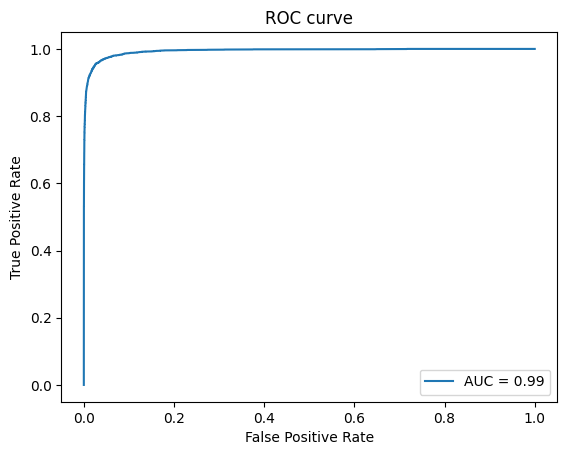

In [12]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_hls)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(['AUC = {:.2f}'.format(metrics.roc_auc_score(y_test, y_hls))])
plt.show()

# Build

Now we are ready to build the bitfile that will be deployed and executed directly on the PYNQ-Z2 FPGA board.  
This process is similar to the previous steps used for building the generic "debugging" firmware, but with a few important differences:

- We configure Conifer to target the specific PYNQ-Z2 board by setting the appropriate board and part number in the configuration dictionary.
- We enable additional options such as `bitfile=True` and `package=True` to ensure that the output includes the FPGA bitstream and all necessary files for deployment.
- The resulting bitfile can be loaded onto the PYNQ-Z2 board, allowing us to run inference on real hardware.

In [13]:
pynq_model_cfg = conifer.backends.xilinxhls.auto_config()
pynq_model_cfg['OutputDir'] = 'prj_conifer_pynq'          # choose a new project directory
pynq_model_cfg['ProjectName'] = 'conifer_xgboost_moons'
pynq_model_cfg['AcceleratorConfig'] = {'Board' : 'pynq-z2',      # choose a pynq-z2 board
                                       'InterfaceType' : 'float' # floating point for the data I/O (this is default)
                                      }
pynq_model_cfg['vivado_config'] = {
    'verbose': True  # Enable verbose output for the Vivado part of the build
}

pynq_model_cfg['hls_config'] = {
    'verbose': True  # Enable verbose output for the HLS part of the build
}
pynq_model_cfg['XilinxPart'] = 'xc7z020clg400-1' # Pynq-Z2 part number

In [14]:
pynq_model = conifer.model.load_model('conifer/my_prj.json', new_config=pynq_model_cfg)
pynq_model.write()

We now set `bitfile=True` because we want Conifer to generate the bitfile we will run on the board

In [15]:
pynq_model.build(synth=True, bitfile=True, package=True)

True